A Dataset containing an A/B test done by an Advertising agency

Данные:

Columns Description

**auction_id:** the unique id of the online user who has been presented the BIO. In standard terminologies this is called an impression id. The user may see the BIO questionnaire but choose not to respond. In that case both the yes and no columns are zero.

**experiment:** which group the user belongs to - control or exposed.

**control:** users who have been shown a dummy ad

**exposed:** users who have been shown a creative, an online interactive ad, with the SmartAd brand.

**date:** the date in YYYY-MM-DD format

**hour:** the hour of the day in HH format.

**device_make:** the name of the type of device the user has e.g. Samsung

**platform_os:** the id of the OS the user has.

**browser:** the name of the browser the user uses to see the BIO questionnaire.

**yes:** 1 if the user chooses the “Yes” radio button for the BIO questionnaire.

**no:** 1 if the user chooses the “No” radio button for the BIO questionnaire.

https://www.kaggle.com/datasets/osuolaleemmanuel/ad-ab-testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
from tqdm import tqdm

In [2]:
# 2 теории 1 что люди стали чаще обращать внимание на окно и взаимодействовать с ним. 2 что конверсия выросла

In [3]:
all_data = pd.read_csv(r'../data/AdSmartABdata - AdSmartABdata.csv')
all_data.head()


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


Посмотрев на данные, можно выдвинуть несколько теорий. 

1. Реклама стала привлекать больше внимания пользователя. Пользователи стали чаще взаимодействовать с формой. CTR вырос.
2. Количество положительных откликов увеличилось.

Для начала проведем EDA(Разведочный анализ данных):

In [4]:
all_data.isna().sum()

auction_id     0
experiment     0
date           0
hour           0
device_make    0
platform_os    0
browser        0
yes            0
no             0
dtype: int64

In [5]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [6]:
all_data.describe()

,hour,platform_os,yes,no
count,8077.000000,8077.000000,8077.000000,8077.000000
mean,11.615080,5.947134,0.070818,0.083075
std,5.734879,0.224333,0.256537,0.276013
min,0.000000,5.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,0.000000
50%,13.000000,6.000000,0.000000,0.000000
75%,15.000000,6.000000,0.000000,0.000000
max,23.000000,7.000000,1.000000,1.000000


In [7]:
print(f'shape: {all_data.shape} \ndevice_make nunique: {all_data.auction_id.nunique()} \nplatform_os nunique: {all_data.platform_os.nunique()} \nbrowser nunique: {all_data.browser.nunique()}')

shape: (8077, 9) 
device_make nunique: 8077 
platform_os nunique: 3 
browser nunique: 15


In [8]:
all_data.platform_os.value_counts()

platform_os
6    7648
5     428
7       1
Name: count, dtype: int64

In [9]:
all_data[all_data.platform_os == 7]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
2332,4c4332e4-25ce-483b-a565-76a76a802ca6,exposed,2020-07-03,13,Lumia 950,7,Edge Mobile,0,0


In [10]:
all_data['not_responded'] = (all_data.yes == all_data.no).astype(int)
all_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no,not_responded
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0,1
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0,1
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1,0
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0,1
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0,1


In [11]:
all_data.groupby(['platform_os', 'experiment']).agg({'yes': pd.Series.mean, 'no': pd.Series.mean, 'not_responded': pd.Series.mean}).round(2)

yes    no  not_responded
platform_os experiment                           
5           control     0.01  0.03           0.96
            exposed     0.01  0.02           0.97
6           control     0.07  0.08           0.85
            exposed     0.08  0.09           0.83
7           exposed     0.00  0.00           1.00

In [12]:
all_data.groupby(['date'], as_index=False).agg({'yes': pd.Series.mean, 'no': pd.Series.mean, 'not_responded': pd.Series.mean}).round(2)

,date,yes,no,not_responded
0,2020-07-03,0.07,0.09,0.84
1,2020-07-04,0.08,0.09,0.82
2,2020-07-05,0.06,0.07,0.87
3,2020-07-06,0.07,0.08,0.85
4,2020-07-07,0.08,0.09,0.83
5,2020-07-08,0.07,0.08,0.85
6,2020-07-09,0.07,0.08,0.85
7,2020-07-10,0.06,0.08,0.86


In [13]:
all_data.groupby(['hour'], as_index=False).agg({'yes': pd.Series.mean, 'no': pd.Series.mean, 'not_responded': pd.Series.mean}).round(2)

,hour,yes,no,not_responded
0,0,0.08,0.08,0.84
1,1,0.05,0.09,0.86
2,2,0.05,0.09,0.86
3,3,0.06,0.11,0.83
4,4,0.08,0.09,0.84
5,5,0.06,0.10,0.84
6,6,0.09,0.06,0.85
7,7,0.06,0.09,0.85
8,8,0.08,0.09,0.83
9,9,0.08,0.08,0.84


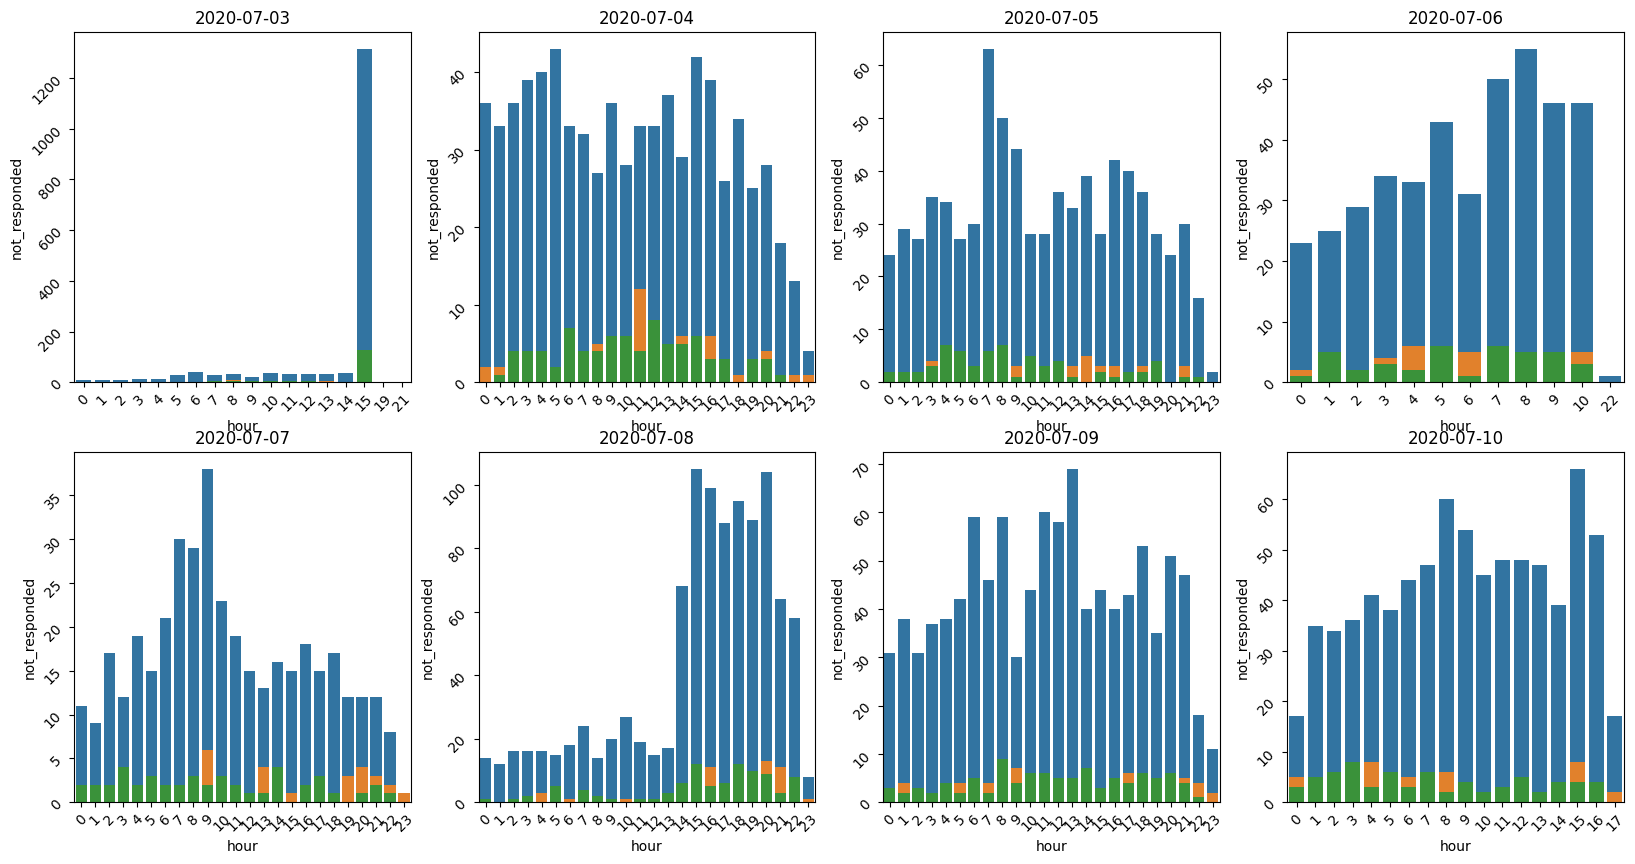

In [14]:
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i, date in enumerate(sorted(all_data.date.unique())):
    ax_ = all_data[all_data.date == date] \
        .groupby('hour', as_index=False) \
        .agg({'yes': pd.Series.sum, 'no': pd.Series.sum, 'not_responded': pd.Series.sum})
    j = int(i/4)
    ax[j, i%4].tick_params(labelrotation=45)
    ax[j, i%4].title.set_text(date)
    sns.barplot(x=ax_.hour, y=ax_.not_responded, ax=ax[j, i%4])
    sns.barplot(x=ax_.hour, y=ax_.yes, ax=ax[j, i%4])
    sns.barplot(x=ax_.hour, y=ax_.no, ax=ax[j, i%4])

**2020-07-03 в 15:00** наблюдается **аномальный всплеск активности**. Возможно произошел какой-то сбой, или по какой-то причине пользователи стали массово посещать сайт, или ошибка в подсчете активности пользователей... Причин может быть много. По хорошему, следует разобраться в причине этого явления. Но, к сожалению, у нас нет такой возможности.

In [15]:
all_data[all_data.date == '2020-07-03'].groupby(['platform_os', 'hour']).agg({'yes': pd.Series.sum, 'no': pd.Series.sum, 'not_responded': pd.Series.sum})

yes   no  not_responded
platform_os hour                         
5           1       0    0              1
            2       0    0              1
            3       0    0              1
            6       0    0              2
            8       0    1              0
            9       0    0              1
            11      0    0              1
            12      0    0              1
            13      0    0              1
            14      0    0              2
            15      0    4             97
6           0       2    3              7
            1       2    3              8
            2       3    1              6
            3       1    2             12
            4       0    2             14
            5       3    1             30
            6       3    0             39
            7       5    6             30
            8       7    3             33
            9       4    6             20
            10      5    6             38
            11      1    6             30
            12      1    5             30
            13      5    1             31
            14      1    3             35
            15    104  124           1217
            19      0    1              0
            21      0    0              1
7           13      0    0              1

In [16]:
pd.set_option('display.max_rows', 75)
all_data[all_data.date == '2020-07-03'].groupby(['browser', 'hour']).agg({'yes': pd.Series.sum, 'no': pd.Series.sum, 'not_responded': pd.Series.sum})

yes  no  not_responded
browser                    hour                        
Android                    15      0   0              1
Chrome                     15      0   1              0
Chrome Mobile              0       1   3              4
                           1       1   2              6
                           2       2   1              2
                           3       0   1              6
                           4       0   2              6
                           5       1   1             13
                           6       1   0             19
                           7       3   4             13
                           8       3   3             13
                           9       1   3              8
                           10      2   2             21
                           11      0   5             20
                           12      0   3             18
                           13      3   0             21
                           14      1   2             15
                           15     55  70            779
Chrome Mobile WebView      0       1   0              3
                           1       1   0              0
                           2       0   0              4
                           3       1   1              3
                           4       0   0              8
                           5       2   0             17
                           6       1   0             17
                           7       2   2             13
                           8       4   0             16
                           9       3   2             11
                           10      2   3              9
                           11      0   1              6
                           12      1   1              7
                           13      2   1              7
                           14      0   1             16
                           15      5  11             77
Chrome Mobile iOS          1       0   0              1
                           2       0   0              1
                           14      0   0              1
                           15      0   0             13
Edge Mobile                13      0   0              1
Facebook                   3       0   0              3
                           7       0   0              2
                           8       0   0              1
                           9       0   1              1
                           10      0   0              3
                           11      1   0              2
                           12      0   1              1
                           13      0   0              1
                           14      0   0              2
                           15     22  22            201
Mobile Safari              3       0   0              1
                           6       0   0              2
                           8       0   1              0
                           9       0   0              1
                           11      0   0              1
                           12      0   0              1
                           13      0   0              1
                           14      0   0              1
                           15      0   3             77
                           19      0   1              0
Mobile Safari UI/WKWebView 6       0   0              1
                           15      0   1              6
Opera Mini                 15      0   0              1
Pinterest                  15      0   0              1
Samsung Internet           1       0   1              2
                           2       1   0              0
                           6       1   0              2
                           7       0   0              2
                           8       0   0              3
                           10      1   1              5
                           11      0   0              2
 

In [17]:
pd.set_option('display.max_rows', 50)
all_data[all_data.date == '2020-07-03'].groupby(['experiment', 'hour']).agg({'yes': pd.Series.sum, 'no': pd.Series.sum, 'not_responded': pd.Series.sum})

yes   no  not_responded
experiment hour                         
control    8       0    0              1
           14      0    0              1
           15    104  128           1309
           19      0    1              0
           21      0    0              1
exposed    0       2    3              7
           1       2    3              9
           2       3    1              7
           3       1    2             13
           4       0    2             14
           5       3    1             30
           6       3    0             41
           7       5    6             30
           8       7    4             32
           9       4    6             21
           10      5    6             38
           11      1    6             31
           12      1    5             31
           13      5    1             33
           14      1    3             36
           15      0    0              5

Всплеск активности наблюдается **на всех платформах** и **во всех браузерах**, но **только в контрольной группе**. Располагая такими данными говорить о причинах такого явления с полной увереностью тяжело. Но, вероятнее всего, это техническая ошибка. Будем работать с имеющимися данными.

In [18]:
pd.set_option('display.max_rows', 10)
all_data.columns

Index(['auction_id', 'experiment', 'date', 'hour', 'device_make',
       'platform_os', 'browser', 'yes', 'no', 'not_responded'],
      dtype='object')


> ## Перейдем к проверке гипотез.

### 1. Пользователи чаще взаимодействуют с новой формой рекламы.
 - **H0** - Доля взаимодействий осталось прежним.
 - **H1** - Доля взаимодействий изменилось.

Так как целевой признак является номинативным, то для проверки гипотезы воспользуемся критерием $\chi2$:

In [19]:
df = all_data.drop(columns=['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser', 'yes', 'no'])
df.head()

,experiment,not_responded
0,exposed,1
1,exposed,1
2,exposed,0
3,control,1
4,control,1


In [20]:
df.experiment.value_counts()

experiment
control    4071
exposed    4006
Name: count, dtype: int64

In [21]:
df.groupby('experiment').agg({'not_responded': pd.Series.mean}).round(2)

,not_responded
experiment,
control,0.86
exposed,0.84


In [22]:
c_ = pd.crosstab(df.experiment, df.not_responded)
c_

not_responded,0,1
experiment,,
control,586,3485
exposed,657,3349


In [23]:
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(6.086192520775971), pvalue=np.float64(0.013624237436461536), dof=1, expected_freq=array([[ 626.5015476, 3444.4984524],
       [ 616.4984524, 3389.5015476]]))

Основываясь на текущих данных, у нас **нет оснований не отклонить нулевую гипотезу** о том, что CTR значимо изменился. Пользователи **стали чаще взаимодействовать** с рекламной формой.

### 1. Пользователи стали чаще соглашаться на заполнение BIO.
 - **H0** - Доля согласий не изменилась.
 - **H1** - ... изменилась.

Так как целевой признак является номинативным, то для проверки гипотезы воспользуемся критерием $\chi2$:

In [24]:
df2 = all_data.drop(columns=['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser', 'not_responded'])
df2.head()

,experiment,yes,no
0,exposed,0,0
1,exposed,0,0
2,exposed,0,1
3,control,0,0
4,control,0,0


In [25]:
df2 = df2[df2.yes+df2.no != 0]
df2.head()

,experiment,yes,no
2,exposed,0,1
16,exposed,1,0
20,exposed,0,1
23,control,1,0
27,control,0,1


In [26]:
df2.groupby('experiment').agg({'yes': pd.Series.mean})

,yes
experiment,
control,0.450512
exposed,0.468798


In [27]:
c_ = pd.crosstab(df2.experiment, df2.yes)

In [28]:
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(0.3465426444731172), pvalue=np.float64(0.5560768104229136), dof=1, expected_freq=array([[316.33628319, 269.66371681],
       [354.66371681, 302.33628319]]))

Опираясь на текущий набор данных, у нас **нет оснований отклонить нулевую гипотезу**. Пользователи не стали чаще соглашаться на заполнение формы.

---

Дополнительно проверим прошлую гипотезу в разрезе платформы, может так оказаться, что на какой-то из платформ мы получим статистически-значимые различия.

In [29]:
df3 = all_data.drop(columns=['auction_id', 'date', 'hour', 'device_make', 'browser', 'not_responded'])
df3 = df3[df3.yes+df3.no != 0]

In [30]:
platform_6 = df3[df3.platform_os == 6]
c_ = pd.crosstab(platform_6.experiment, platform_6.yes)
c_

yes,0,1
experiment,,
control,313,260
exposed,346,307


In [31]:
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(0.2670038881920658), pvalue=np.float64(0.6053487074729833), dof=1, expected_freq=array([[307.99918434, 265.00081566],
       [351.00081566, 301.99918434]]))

In [32]:
platform_5 = df3[df3.platform_os == 5]
c_ = pd.crosstab(platform_5.experiment, platform_5.yes)
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(0.0), pvalue=np.float64(1.0), dof=1, expected_freq=array([[9.17647059, 3.82352941],
       [2.82352941, 1.17647059]]))

Однако, что случится, если выбросить данные в час всплеска, сильно ли они повлияли на проверку гипотез?

--- 

### Первое предположение о том, что пользователи стали чаще взаимодействовать с формой.

In [33]:
all_data_no_2020_07_03_15 = all_data[(all_data.date != '2020-07-03') | (all_data.hour != 15)]
all_data_no_2020_07_03_15.shape

(6531, 10)

In [34]:
df2 = all_data_no_2020_07_03_15.drop(columns=['auction_id', 'date', 'hour', 'device_make', 'platform_os', 'browser', 'yes', 'no'])
df2.head()

,experiment,not_responded
0,exposed,1
1,exposed,1
2,exposed,0
7,control,1
8,exposed,1


In [35]:
df2.not_responded.value_counts()

not_responded
1    5520
0    1011
Name: count, dtype: int64

In [36]:
df2.groupby('experiment').not_responded.mean()

experiment
control    0.860079
exposed    0.835791
Name: not_responded, dtype: float64

In [37]:
c_ = pd.crosstab(df2.experiment, df2.not_responded)

In [38]:
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(6.803743886815533), pvalue=np.float64(0.009096692637287414), dof=1, expected_freq=array([[ 391.64446486, 2138.35553514],
       [ 619.35553514, 3381.64446486]]))

Отклоняем нулевую гипотезу как и в первом случае. 

### Проверим второе предположение, что пользватели стали чаще соглашаться с заполнением BIO.

In [40]:
df3 = all_data_no_2020_07_03_15.drop(columns=['auction_id', 'date', 'hour', 'device_make', 'browser', 'not_responded'])
df3.head()

,experiment,platform_os,yes,no
0,exposed,6,0,0
1,exposed,6,0,0
2,exposed,6,0,1
7,control,6,0,0
8,exposed,6,0,0


In [41]:
df3 = df3[df3.yes+df3.no != 0]
df3.head()

,experiment,platform_os,yes,no
2,exposed,6,0,1
16,exposed,6,1,0
20,exposed,6,0,1
23,control,6,1,0
39,exposed,6,0,1


In [43]:
df3.groupby('experiment').agg({'yes': pd.Series.mean})

,yes
experiment,
control,0.451977
exposed,0.468798


In [45]:
c_ = pd.crosstab(df3.experiment, df3.yes)
sc.chi2_contingency(c_)

Chi2ContingencyResult(statistic=np.float64(0.19849685396524916), pvalue=np.float64(0.6559368876117577), dof=1, expected_freq=array([[190.1305638, 163.8694362],
       [352.8694362, 304.1305638]]))

И в данном случае нет оснований отклонить нулевую гипотезу. Таким образом, всплеск 2020-07-03 не оказал значимого влияния.

## Вывод: 

Катим новую версию формы, т.к. доля пользователей, взаимодействующих с ней увеличилась. Даже если учесть то, что доля согласий осталась прежней, то общее их количество возрастет из-за повышения кол-ва взаимодействий с формой.
